req         WARNING 	DEFAULT CACHE ENABLED! (886.25 MB) C:\Users\Usuario\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.4.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api      

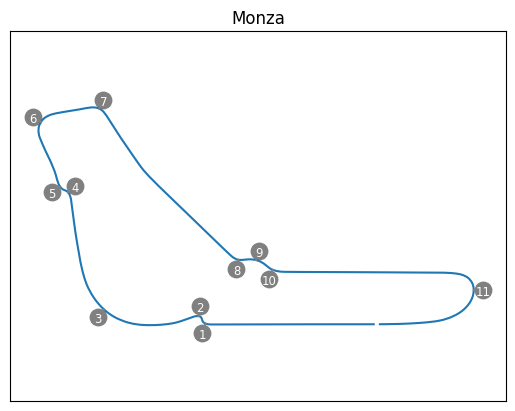

In [1]:
"""Draw a track map with numbered corners
=========================================

Use the position data of a single lap to draw a track map.
Then annotate the map with corner numbers.
"""
##############################################################################
# Import FastF1 and load the data. Use the telemetry from the fastest for the
# track map. (You could also use any other lap instead.)

import matplotlib.pyplot as plt
import numpy as np

import fastf1


session = fastf1.get_session(2024, 'Monza', 'Q')
session.load()

lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

circuit_info = session.get_circuit_info()


##############################################################################
# Define a helper function for rotating points around the origin of the
# coordinate system.
#
# The matrix ``[[cos, sin], [-sin, cos]]`` is called a rotation matrix.
#
# By matrix multiplication of the rotation matrix with a vector [x, y], a new
# rotated vector [x_rot, y_rot] is obtained.
# (See also: https://en.wikipedia.org/wiki/Rotation_matrix)

def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)


##############################################################################
# Get the coordinates of the track map from the telemetry of the lap and
# rotate the coordinates using the rotation from ``circuit_info`` so that
# the track map is oriented correctly. After that, plot the rotated track map.

# Get an array of shape [n, 2] where n is the number of points and the second
# axis is x and y.
track = pos.loc[:, ('X', 'Y')].to_numpy()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate and plot the track map.
rotated_track = rotate(track, angle=track_angle)
plt.plot(rotated_track[:, 0], rotated_track[:, 1])

# sphinx_gallery_defer_figures


##############################################################################
# Finally, the corner markers are plotted. To plot the numbers next to the
# track, an offset vector that points straight up is defined. This offset
# vector is then rotated by the angle that is given for each corner marker.
# A line and circular bubble are drawn and the corner marker text is printed
# inside the bubble.

offset_vector = [500, 0]  # offset length is chosen arbitrarily to 'look good'

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')

# sphinx_gallery_defer_figures


##############################################################################
# Add a title, remove tick labels to clean up the plot, set equal axis ratio,
# so that the track is not distorted and show the plot.

plt.title(session.event['Location'])
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from timple.timedelta import strftimedelta

import fastf1
import fastf1.plotting
from fastf1.core import Laps


# Enable Matplotlib patches for plotting timedelta values
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme=None)


session = fastf1.get_session(2024, 'Azerbaijan', 'Q')
session.load()

core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.4.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            IN

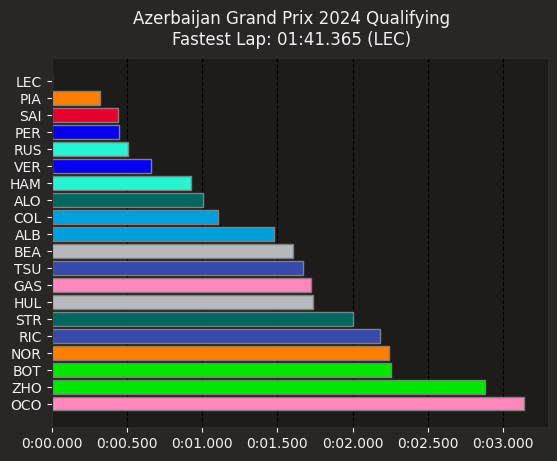

In [7]:
drivers = pd.unique(session.laps['Driver'])


list_fastest_laps = list()
for drv in drivers:
    drvs_fastest_lap = session.laps.pick_driver(drv).pick_fastest()
    list_fastest_laps.append(drvs_fastest_lap)
fastest_laps = Laps(list_fastest_laps) \
    .sort_values(by='LapTime') \
    .reset_index(drop=True)

pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']

team_colors = list()
for index, lap in fastest_laps.iterlaps():
    color = fastf1.plotting.get_team_color(lap['Team'], session=session)
    team_colors.append(color)

fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')

plt.suptitle(f"{session.event['EventName']} {session.event.year} Qualifying\n"
             f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")

plt.show()

core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

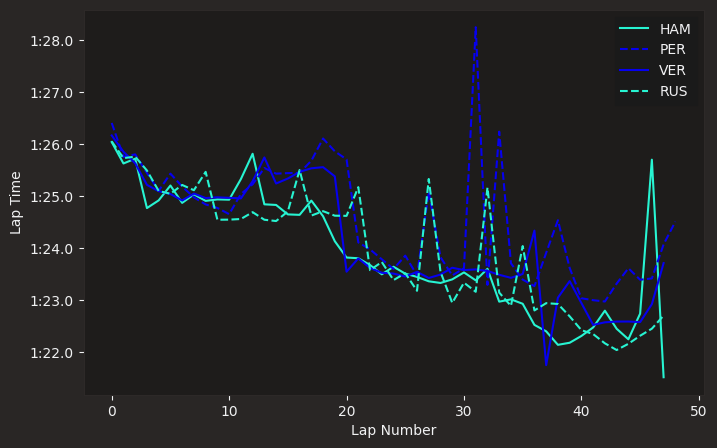

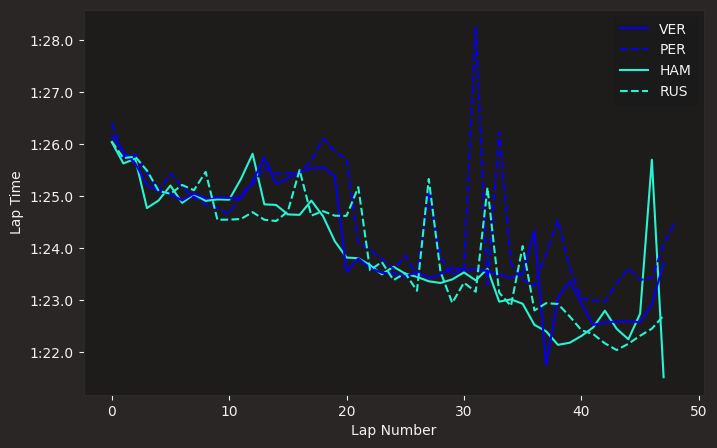

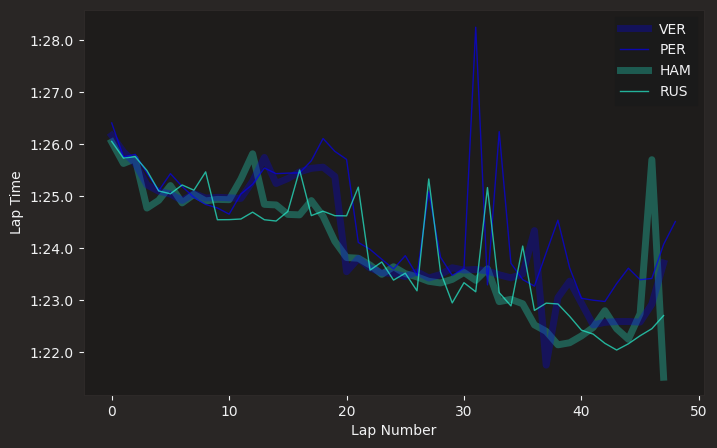

In [2]:
from fastf1 import plotting


# Enable Matplotlib patches for plotting timedelta values and load
# FastF1's dark color scheme
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')


###############################################################################
# Load the race session.

race = fastf1.get_session(2024, "Monza", 'R')
race.load()

###############################################################################
# Basic driver-specific plot styling
# ----------------------------------
# Plot all the laps for Hamilton, Russel, Perez and Verstappen.
# Filter out slow laps as they distort the graph axis.
# Note: as LapTime is represented by timedelta, calling ``setup_mpl`` earlier
# is required.

fig, ax = plt.subplots(figsize=(8, 5))

for driver in ('HAM', 'PER', 'VER', 'RUS'):
    laps = race.laps.pick_driver(driver).pick_quicklaps().reset_index()
    style = plotting.get_driver_style(identifier=driver,
                                      style=['color', 'linestyle'],
                                      session=race)
    ax.plot(laps['LapTime'], **style, label=driver)

# add axis labels and a legend
ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")
ax.legend()

###############################################################################
# Sorting the legend
# ------------------
# That plot looks pretty good already, but the order of the labels in the
# legend is slightly chaotic. Instead of trying to order the labels manually,
# use :func:`fastf1.plotting.add_sorted_driver_legend`.
# Let's create the exact same plot again, but this time with a sorted legend
# which means, we only change the very last function call.

fig, ax = plt.subplots(figsize=(8, 5))

for driver in ('HAM', 'PER', 'VER', 'RUS'):
    laps = race.laps.pick_driver(driver).pick_quicklaps().reset_index()
    style = plotting.get_driver_style(identifier=driver,
                                      style=['color', 'linestyle'],
                                      session=race)
    ax.plot(laps['LapTime'], **style, label=driver)

# add axis labels and a legend
ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")
plotting.add_sorted_driver_legend(ax, race)

###############################################################################
# Creating fully custom styles
# ----------------------------
# If you want to fully customize the plot style, you can define your own
# styling variants.
#
# Note that the value ``'auto'`` is treated as a magic keyword when used in
# combination with a color. It will be replaced with the team color.
#
# We define two styles, one for the first driver and one for the second driver
# in any team.
#
# The plot that is generated here isn't intended to be very readable, but it
# shows how you can customize any plot styling parameter.

my_styles = [
    # style for each first driver
    {'color': 'auto', 'linestyle': 'solid', 'linewidth': 5, 'alpha': 0.3},
    # style for each second driver
    {'color': 'auto', 'linestyle': 'solid', 'linewidth': 1, 'alpha': 0.7}
]

fig, ax = plt.subplots(figsize=(8, 5))

for driver in ('HAM', 'PER', 'VER', 'RUS'):
    laps = race.laps.pick_driver(driver).pick_quicklaps().reset_index()

    # here, we now use ``style=my_style`` to use the custom styling
    style = plotting.get_driver_style(identifier=driver,
                                      style=my_styles,
                                      session=race)

    ax.plot(laps['LapTime'], **style, label=driver)

# add axis labels and a legend
ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")
plotting.add_sorted_driver_legend(ax, race)
plt.show()


core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.4.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No 

['1', '44', '63', '55', '11', '16', '4', '14', '31', '5', '18', '10', '24', '47', '3', '20', '23', '6', '22', '77']
['VER', 'HAM', 'RUS', 'SAI', 'PER', 'LEC', 'NOR', 'ALO', 'OCO', 'VET', 'STR', 'GAS', 'ZHO', 'MSC', 'RIC', 'MAG', 'ALB', 'LAT', 'TSU', 'BOT']
   Driver  Stint Compound  StintLength
0     ALB    1.0     SOFT            2
1     ALB    2.0   MEDIUM           19
2     ALB    3.0   MEDIUM           19
3     ALB    4.0     SOFT           29
4     ALO    1.0   MEDIUM           21
..    ...    ...      ...          ...
57    VET    2.0   MEDIUM           31
58    VET    3.0   MEDIUM           23
59    ZHO    1.0   MEDIUM           27
60    ZHO    2.0     HARD           24
61    ZHO    3.0     SOFT           18

[62 rows x 4 columns]


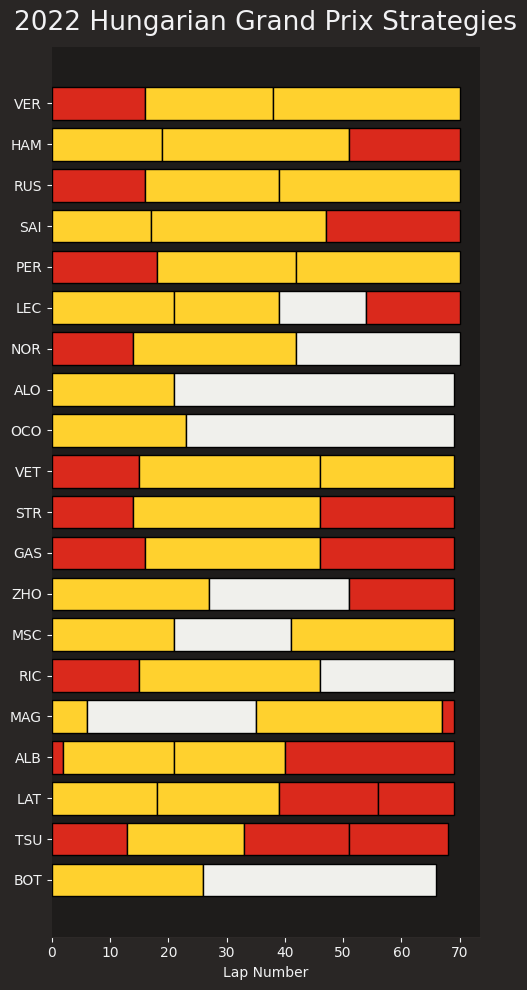

In [3]:

###############################################################################
# Load the race session

session = fastf1.get_session(2022, "Hungary", 'R')
session.load()
laps = session.laps

###############################################################################
# Get the list of driver numbers
drivers = session.drivers
print(drivers)

###############################################################################
# Convert the driver numbers to three letter abbreviations
drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers]
print(drivers)

###############################################################################
# We need to find the stint length and compound used
# for every stint by every driver.
# We do this by first grouping the laps by the driver,
# the stint number, and the compound.
# And then counting the number of laps in each group.
stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()

###############################################################################
# The number in the LapNumber column now stands for the number of observations
# in that group aka the stint length.
stints = stints.rename(columns={"LapNumber": "StintLength"})
print(stints)

###############################################################################
# Now we can plot the strategies for each driver
fig, ax = plt.subplots(figsize=(5, 10))

for driver in drivers:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        compound_color = fastf1.plotting.get_compound_color(row["Compound"],
                                                            session=session)
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=compound_color,
            edgecolor="black",
            fill=True
        )

        previous_stint_end += row["StintLength"]

# sphinx_gallery_defer_figures

###############################################################################
# Make the plot more readable and intuitive
plt.title("2022 Hungarian Grand Prix Strategies")
plt.xlabel("Lap Number")
plt.grid(False)
# invert the y-axis so drivers that finish higher are closer to the top
ax.invert_yaxis()

# sphinx_gallery_defer_figures

###############################################################################
# Plot aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']


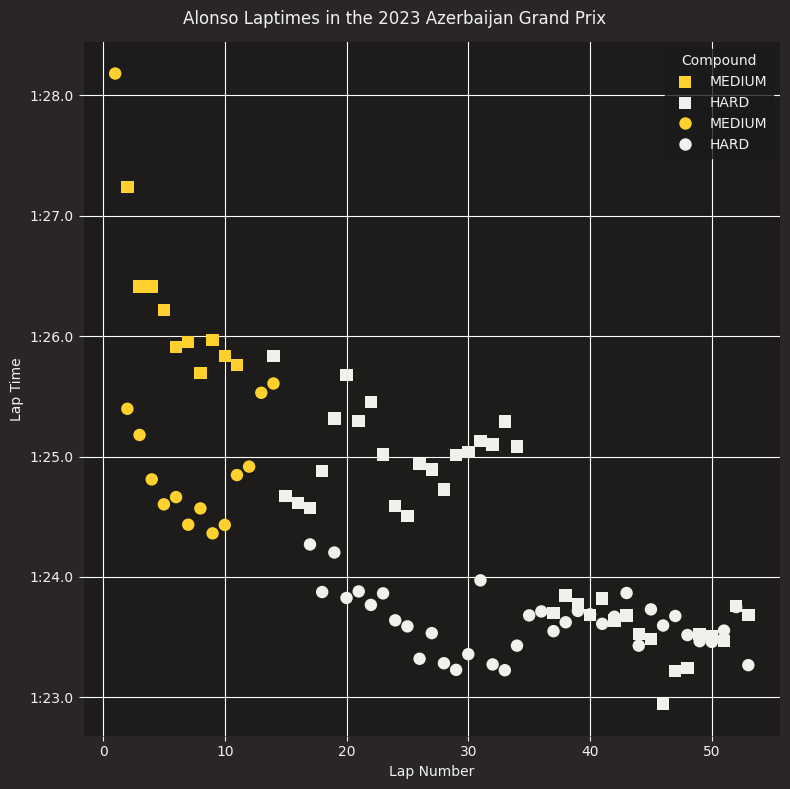

In [18]:
"""Driver Laptimes Scatterplot
==============================

Plot a driver's lap times in a race, with color coding for the compounds.
"""

import seaborn as sns


# Enable Matplotlib patches for plotting timedelta values and load
# FastF1's dark color scheme
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')


###############################################################################
# Load the race session.

race = fastf1.get_session(2024, "Monza", 'R')
race.load()

###############################################################################
# Get all the laps for a single driver.
# Filter out slow laps as they distort the graph axis.

driver_laps_alo = race.laps.pick_driver("ALO").pick_quicklaps().reset_index()
driver_laps_lec = race.laps.pick_driver("LEC").pick_quicklaps().reset_index()

###############################################################################
# Make the scattterplot using lap number as x-axis and lap time as y-axis.
# Marker colors correspond to the compounds used.
# Note: as LapTime is represented by timedelta, calling setup_mpl earlier
# is required.

fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=driver_laps_alo,
                x="LapNumber",
                y="LapTime",
                ax=ax,
                marker='s',
                hue="Compound",
                palette=fastf1.plotting.get_compound_mapping(session=race),
                s=80,
                linewidth=0,
                legend='auto')

sns.scatterplot(data=driver_laps_lec,
                x="LapNumber",
                y="LapTime",
                ax=ax,
                hue="Compound",
                palette=fastf1.plotting.get_compound_mapping(session=race),
                s=80,
                linewidth=0,
                legend='auto')
# sphinx_gallery_defer_figures

###############################################################################
# Make the plot more aesthetic.
ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")

# The y-axis increases from bottom to top by default
# Since we are plotting time, it makes sense to invert the axis
ax.invert_yaxis()
plt.suptitle("Alonso Laptimes in the 2023 Azerbaijan Grand Prix")

# Turn on major grid lines
plt.grid(color='w', which='major', axis='both')
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()
